In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1
import pytorch_lightning as pl
import torch
from torch import nn
import torchvision.models as models
from pytorch_lightning.metrics import MetricCollection, Accuracy, Precision, Recall, ConfusionMatrix, PrecisionRecallCurve
from pytorch_lightning.callbacks import ModelCheckpoint


env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [2]:
class ImEncodeModel(pl.LightningModule):

    def __init__(self):
        super().__init__()
        
        self.image_model = models.resnet18(pretrained=True)
        self.image_model.fc = nn.Sequential()
    
    
    def forward(self, input_image):
        encoding = self.image_model(input_image)
        return encoding

In [55]:
class FirstModel(pl.LightningModule):

    def __init__(self):
        super().__init__()
        
        ##THIS PATH NEEDS TO BE MODIFIED TO AN RESNET-18 THAT HAS BEEN PRETRAINED WITH A TRIPLET LOSS
        self.image_model = ImEncodeModel.load_from_checkpoint(checkpoint_path=\
                                                              '/home/dennis/agriculture/lightning_logs/version_93/checkpoints/epoch=25-step=5615.ckpt')
        
        self.predictor = nn.Sequential(nn.Linear(512*2, 512),
                                       nn.ReLU(),
                                       nn.Linear(512,256),
                                       nn.ReLU(),
                                       nn.Linear(256,128),
                                       nn.ReLU(),
                                       nn.Linear(128,64),
                                       nn.ReLU(),
                                       nn.Linear(64,32),
                                       nn.ReLU(),
                                       nn.Linear(32,1))

        
        self.train_metrics = MetricCollection({
                                                "tr/acc": Accuracy(threshold = 0.5),
                                                "tr/precision":Precision(is_multiclass = False, threshold = 0.5),
                                                "tr/recall":Recall(is_multiclass = False, threshold = 0.5),
                                                
        })
        self.valid_metrics = MetricCollection({
                                                "val/acc": Accuracy(threshold = 0.5),
                                                "val/precision":Precision(is_multiclass = False, threshold = 0.5),
                                                "val/recall":Recall(is_multiclass = False, threshold = 0.5)
        })
        self.test_metrics = MetricCollection({
                                                "test/acc": Accuracy(threshold = 0.5),
                                                "test/precision":Precision(is_multiclass = False, threshold = 0.5),
                                                "test/recall":Recall(is_multiclass = False, threshold = 0.5)
        })
        

        self.confmat = ConfusionMatrix(num_classes=2, threshold = 0.5)
        self.prc = PrecisionRecallCurve(num_classes = 1)
    
    def loss(self,x,y, weight = None):
        if weight is None:
            return nn.functional.binary_cross_entropy_with_logits(x.squeeze(),y.squeeze())
        else:
            return nn.functional.binary_cross_entropy_with_logits(x.squeeze(),y.squeeze(), weight = weight.squeeze())
    
    def forward(self, healthy_image, unknown_image):
        encoded_healthy_image = self.image_model(healthy_image)#.permute(0,3,1,2))
        encoded_unknown_image = self.image_model(unknown_image)#.permute(0,3,1,2))
        #distance_matrix_line = self.distance_matrix_predictor(torch.cat((encoded_healthy_image, encoded_unknown_image), -1))
        #distance_matrix = torch.einsum("bn,bo->bno", distance_matrix_line, distance_matrix_line)
        #distance = torch.einsum("bi,bij,bj->b", encoded_healthy_image, distance_matrix, encoded_unknown_image)
        #prediction = self.distance_predictor(distance.unsqueeze(-1))
        prediction = self.predictor(torch.cat((encoded_healthy_image, encoded_unknown_image), -1))
        return prediction

    def training_step(self, batch, batch_idx):
        prediction = self.forward(batch['healthy image'], batch['unknown image'])

        # reconstruction
        reconstruction_loss = self.loss(prediction, batch['label'], batch['weight'])
        self.log("tr/loss", reconstruction_loss)
        
        self.train_metrics(torch.sigmoid(prediction), batch['label'].squeeze().long())
        self.log_dict(self.train_metrics, on_step=True, on_epoch=True)
        return reconstruction_loss

    def validation_step(self, batch, batch_idx):
        prediction = self.forward(batch['healthy image'], batch['unknown image'])
        # reconstruction
        reconstruction_loss = self.loss(prediction, batch['label'], batch['weight'])
        self.log("val/loss", reconstruction_loss)
        
        self.valid_metrics(torch.sigmoid(prediction), batch['label'].squeeze().long())
        self.log_dict(self.valid_metrics, on_step=False, on_epoch=True)
        
        return reconstruction_loss
    
    def test_step(self, batch, batch_idx):
        
        prediction = self.forward(batch['healthy image'], batch['unknown image'])
        # reconstruction
        reconstruction_loss = self.loss(prediction, batch['label'], batch['weight'])
        self.log("test/loss", reconstruction_loss)
        
        self.test_metrics(torch.sigmoid(prediction), batch['label'].squeeze().long())
        self.log_dict(self.test_metrics, on_step=False, on_epoch=True)
        self.confmat.update(torch.sigmoid(prediction), batch['label'].squeeze().long())
        #print(torch.sigmoid(prediction).shape)
        self.prc.update(torch.sigmoid(prediction).squeeze(), batch['label'].squeeze().long())
        return reconstruction_loss
        

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.000002)

In [56]:
from datamodule import ZeroShotDataModule
dm = ZeroShotDataModule(batch_size = 64, 
                        test_plants = 'all', 
                        train_plants = ['Strawberry', 'Tomato'])
dm.setup()

plants in this dataset: ['Strawberry', 'Tomato']
Strawberry, healthy: 319
Strawberry, Leaf_scorch: 776
Tomato, Septoria_leaf_spot: 1239
Tomato, Leaf_Mold: 666
Tomato, healthy: 1113
Tomato, Spider_mites Two-spotted_spider_mite: 1173
Tomato, Late_blight: 1336
Tomato, Bacterial_spot: 1488
Tomato, Early_blight: 700
Tomato, Tomato_Yellow_Leaf_Curl_Virus: 3749
Tomato, Tomato_mosaic_virus: 261
Tomato, Target_Spot: 982
weight sum: 0.005408180138046165
weights: {'Strawberry': {'healthy': 0.5796397601831796, 'unhealthy': 0.23827974677633285}, 'Tomato': {'healthy': 0.16613215049275318, 'unhealthy': 0.015948342547734543}}


plants in this dataset: ['Strawberry', 'Tomato']
Strawberry, healthy: 68
Strawberry, Leaf_scorch: 166
Tomato, Septoria_leaf_spot: 266
Tomato, Leaf_Mold: 143
Tomato, healthy: 238
Tomato, Spider_mites Two-spotted_spider_mite: 251
Tomato, Late_blight: 286
Tomato, Bacterial_spot: 319
Tomato, Early_blight: 150
Tomato, Tomato_Yellow_Leaf_Curl_Virus: 804
Tomato, Tomato_mosaic_virus: 5

In [57]:
model = FirstModel()
checkpoint_callback = ModelCheckpoint(monitor='val/loss')
trainer = pl.Trainer(gpus = 1, max_epochs = 650, log_every_n_steps=1, fast_dev_run = False, callbacks = checkpoint_callback)
trainer.fit(model, dm)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name          | Type                 | Params
-------------------------------------------------------
0 | image_model   | ImEncodeModel        | 11.2 M
1 | predictor     | Sequential           | 699 K 
2 | train_metrics | MetricCollection     | 0     
3 | valid_metrics | MetricCollection     | 0     
4 | test_metrics  | MetricCollection     | 0     
5 | confmat       | ConfusionMatrix      | 0     
6 | prc           | PrecisionRecallCurve | 0     
-------------------------------------------------------
11.9 M    Trainable params
0         Non-trainable params
11.9 M    Total params
47.504    Total estimated model params size (MB)


1

In [58]:
model = FirstModel.load_from_checkpoint(checkpoint_path = checkpoint_callback.best_model_path)

In [59]:
print(checkpoint_callback.best_model_path)

/home/dennis/agriculture/lightning_logs/version_94/checkpoints/epoch=12-step=2807.ckpt


In [60]:
res = trainer.test(model, datamodule=dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/acc': 0.8481622934341431,
 'test/loss': 0.01288200356066227,
 'test/precision': 0.9783281683921814,
 'test/recall': 0.2585924565792084}
--------------------------------------------------------------------------------


tensor([[4784.,    7.],
        [ 906.,  316.]], device='cuda:0')


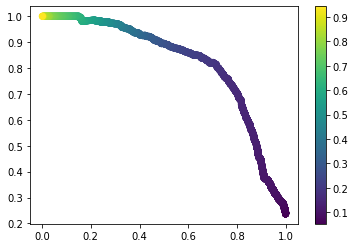

In [61]:
print(model.confmat.compute())
precision, recall, thresholds = model.prc.compute()
import matplotlib.pyplot as plt
#print(thresholds)
plt.scatter(recall[:-1].cpu().numpy(), precision[:-1].cpu().numpy(), c= thresholds.cpu().numpy().squeeze())
plt.colorbar()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Apple



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/acc': 0.5146443247795105,
 'test/loss': 0.40966928005218506,
 'test/precision': 0.7777777910232544,
 'test/recall': 0.08502024412155151}
--------------------------------------------------------------------------------
tensor([[  0., 231.],
        [  0., 247.]], device='cuda:0')


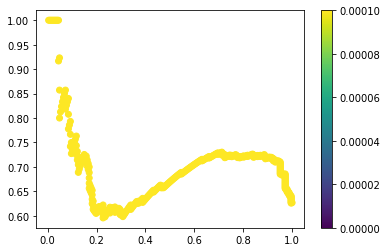

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Cherry_(including_sour)



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/acc': 0.6573426723480225,
 'test/loss': 0.3216174840927124,
 'test/precision': 1.0,
 'test/recall': 0.234375}
--------------------------------------------------------------------------------
tensor([[  0., 158.],
        [  0., 128.]], device='cuda:0')


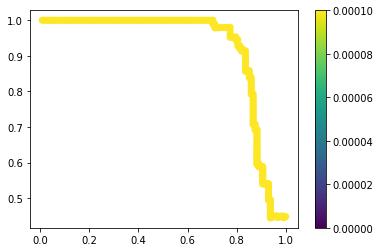

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Corn_(maize)



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/acc': 0.7461140155792236,
 'test/loss': 0.34373655915260315,
 'test/precision': 1.0,
 'test/recall': 0.1599999964237213}
--------------------------------------------------------------------------------
tensor([[  0., 404.],
        [  0., 175.]], device='cuda:0')


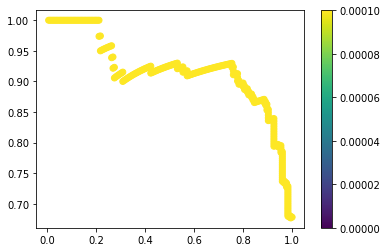

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Grape



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/acc': 0.9410802125930786,
 'test/loss': 0.10231833159923553,
 'test/precision': 1.0,
 'test/recall': 0.4375}
--------------------------------------------------------------------------------
tensor([[  0., 547.],
        [  0.,  64.]], device='cuda:0')


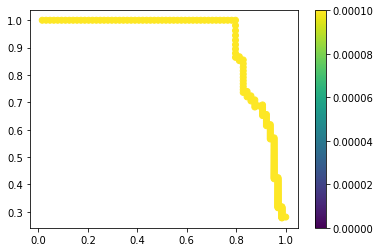

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Peach



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/acc': 0.862500011920929,
 'test/loss': 0.2806248068809509,
 'test/precision': 0.0,
 'test/recall': 0.0}
--------------------------------------------------------------------------------
tensor([[  0., 345.],
        [  0.,  55.]], device='cuda:0')


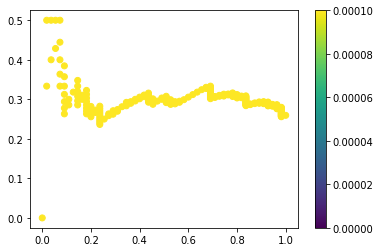

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Pepper,_bell



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/acc': 0.5295698642730713,
 'test/loss': 0.3528211712837219,
 'test/precision': 1.0,
 'test/recall': 0.21171170473098755}
--------------------------------------------------------------------------------
tensor([[  0., 150.],
        [  0., 222.]], device='cuda:0')


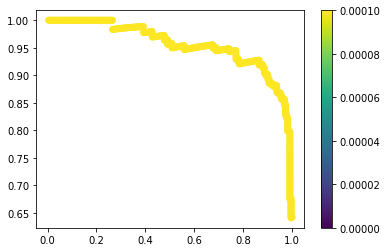

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Potato



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/acc': 0.9690402746200562,
 'test/loss': 0.05455993115901947,
 'test/precision': 0.9333333373069763,
 'test/recall': 0.6086956262588501}
--------------------------------------------------------------------------------
tensor([[  0., 300.],
        [  0.,  23.]], device='cuda:0')


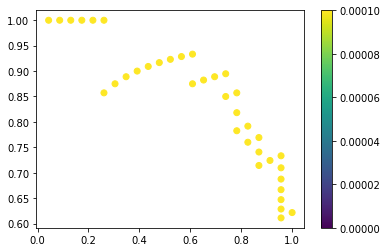

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Strawberry



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/acc': 0.9745762944221497,
 'test/loss': 0.08755472302436829,
 'test/precision': 1.0,
 'test/recall': 0.9130434989929199}
--------------------------------------------------------------------------------
tensor([[  0., 167.],
        [  0.,  69.]], device='cuda:0')


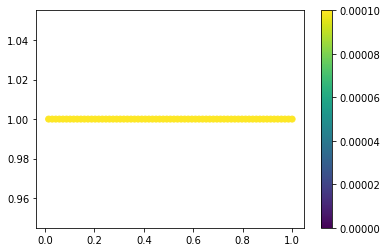

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Tomato



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/acc': 0.9439149498939514,
 'test/loss': 0.08419464528560638,
 'test/precision': 1.0,
 'test/recall': 0.35983264446258545}
--------------------------------------------------------------------------------
tensor([[   0., 2489.],
        [   0.,  239.]], device='cuda:0')


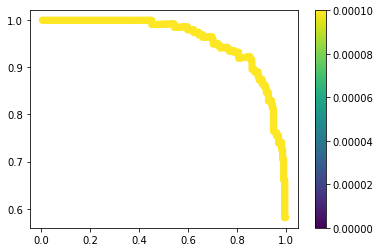

In [62]:
for (plant_name, dl) in dm.test_indiv_plants_dataloaders().items():
    model.confmat.reset()
    model.prc.reset()

    print(plant_name)
    res = trainer.test(model, test_dataloaders= dl)
    print(model.confmat.compute())
    precision, recall, thresholds = model.prc.compute()
    plt.scatter(recall[:-1].cpu().numpy(), precision[:-1].cpu().numpy(), c= thresholds.cpu().numpy().squeeze(), vmin = 0, vmax = 0.0001)
    plt.colorbar()
    plt.show()
    

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Apple



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/acc': 0.5146443247795105,
 'test/loss': 0.40966928005218506,
 'test/precision': 0.7777777910232544,
 'test/recall': 0.08502024412155151}
--------------------------------------------------------------------------------
tensor([[140.,  91.],
        [ 19., 228.]], device='cuda:0')


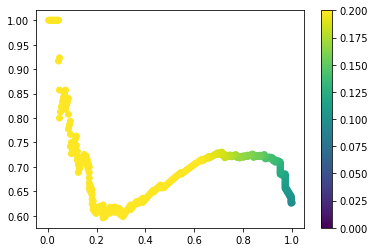

In [67]:
import numpy as np
for (plant_name, dl) in dm.test_indiv_plants_dataloaders().items():
    if plant_name != "Apple":
        continue
    model.confmat.reset()
    model.prc.reset()


    ## THIS PARAMETER OFTEN HAS TO BE TWEAKED FOR MAXIMUM PERFORMANCE, BUT USUALLY FALLS AROUND 0.1
    model.confmat.threshold = 0.135
    print(plant_name)
    res = trainer.test(model, test_dataloaders= dl)
    cm = model.confmat.compute()
    print(cm)
    precision, recall, thresholds = model.prc.compute()
    plt.scatter(recall[:-1].cpu().numpy(), precision[:-1].cpu().numpy(), c= thresholds.cpu().numpy().squeeze(), vmin = 0, vmax = 0.2)
    plt.colorbar()
    plt.show()


results_dict = {
    "confusion matrix": cm.cpu().detach().numpy(),
    "model path": checkpoint_callback.best_model_path
}
np.save("initial_model_results/leave_multi_out/leave_seven_out.npy", results_dict)